### Load libraries:

In [1]:
import os
import sys
import cv2
import json
import math 
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset 
from pycocotools.coco import COCO
from PIL import Image
from huggingface_hub import hf_hub_download

sys.path.append(os.path.abspath("../segment-anything-2"))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(),"..")))

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

### Load data

In [3]:
from src.preprocess_data import load_and_split_dataset

In [4]:
HF_REPO_NAME = "peaceAsh/fashion_sam_dataset_v2"
COCO_DATASET = "peaceAsh/fashion_seg_coco_dataset"
JSON_FILE = "result.json"

In [5]:
fashion_ds = load_and_split_dataset(HF_REPO_NAME)
fashion_ds

DatasetDict({
    train: Dataset({
        features: ['image', 'mask', 'filename'],
        num_rows: 13
    })
    validation: Dataset({
        features: ['image', 'mask', 'filename'],
        num_rows: 1
    })
    test: Dataset({
        features: ['image', 'mask', 'filename'],
        num_rows: 2
    })
})

In [6]:
coco_path = hf_hub_download(
    repo_id=COCO_DATASET,
    filename=JSON_FILE,
    repo_type="dataset" 
)

coco = COCO(coco_path)
coco_imgs = coco.loadImgs(coco.getImgIds())
filename_to_ids = {img['file_name'] : img['id'] for img in coco_imgs}

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [7]:
def create_instance_list(dataset,coco,filename_to_ids):
    instance_list = []
    for i in tqdm(range(len(dataset))):
        item = dataset[i]
        base_filename = item['filename']
        coco_filename = base_filename.split('/')[-1]
        img_id = filename_to_ids[coco_filename]
        if img_id is not None:
            anns_ids = coco.getAnnIds(imgIds=img_id)
            anns = coco.loadAnns(anns_ids)
            for ann in anns:
                instance_list.append({
                    "dataset_idx":i,
                    "annotation":ann
                })
    return instance_list



train_instances = create_instance_list(fashion_ds['train'],coco,filename_to_ids)
val_instances = create_instance_list(fashion_ds['validation'],coco,filename_to_ids)

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
class FashionSAMDataset(Dataset):
    def __init__(self, dataset, instance_list, coco_api, image_size=1024, num_pts_per_instance=3):
        self.dataset = dataset
        self.instance_list = instance_list
        self.coco_api = coco_api
        self.image_size = int(image_size)
        self.num_pts_per_instance = int(num_pts_per_instance)

    def __len__(self):
        return len(self.instance_list)

    def _compute_scale_and_pad(self, width, height):
        target = self.image_size
        scale = target / max(width, height)
        new_w = int(round(width * scale))
        new_h = int(round(height * scale))
        pad_left = (target - new_w) // 2
        pad_top = (target - new_h) // 2
        return scale, new_w, new_h, pad_left, pad_top

    def _resize_and_pad_image(self, image):
        w, h = image.size
        scale, new_w, new_h, pad_left, pad_top = self._compute_scale_and_pad(w, h)
        resized = image.resize((new_w, new_h), Image.Resampling.LANCZOS)
        canvas = Image.new("RGB", (self.image_size, self.image_size), (0, 0, 0))
        canvas.paste(resized, (pad_left, pad_top))
        arr = np.array(canvas, dtype=np.uint8)   # H x W x 3
        return arr, (scale, pad_left, pad_top)

    def _resize_and_pad_mask(self, mask, scale, pad_left, pad_top):
        h, w = mask.shape
        new_w = int(round(w * scale))
        new_h = int(round(h * scale))
        if new_w == 0 or new_h == 0:
            padded = np.zeros((self.image_size, self.image_size), dtype=np.uint8)
            return padded
        resized = cv2.resize(mask.astype(np.uint8), (new_w, new_h), interpolation=cv2.INTER_NEAREST)
        padded = np.zeros((self.image_size, self.image_size), dtype=np.uint8)
        padded[pad_top:pad_top + new_h, pad_left:pad_left + new_w] = resized
        return padded

    def _sample_points_from_mask(self, mask, num_points):
        h, w = mask.shape
        kernel = np.ones((3, 3), np.uint8)
        eroded = cv2.erode(mask.astype(np.uint8), kernel, iterations=1)
        coords = np.argwhere(eroded > 0)  # rows=y, cols=x
        if coords.shape[0] == 0:
            coords = np.argwhere(mask > 0)

        if coords.shape[0] == 0:
            return np.empty((0, 2), dtype=np.float32)

        num_available = coords.shape[0]
        k = min(num_points, num_available)
        chosen_idx = np.random.choice(num_available, k, replace=False)
        chosen = coords[chosen_idx]  # (y, x)
        xy = chosen[:, ::-1].astype(np.float32)
        return xy

    def __getitem__(self, idx):
        inst = self.instance_list[idx]
        dataset_idx = inst['dataset_idx']
        annotation = inst['annotation']

        image_pil = self.dataset[dataset_idx]['image'].convert("RGB")
        mask_orig = self.coco_api.annToMask(annotation).astype(np.uint8)  # H x W

        points_orig = self._sample_points_from_mask(mask_orig, self.num_pts_per_instance)  # Nx2 (x,y)

        image_arr, (scale, pad_left, pad_top) = self._resize_and_pad_image(image_pil)
        mask_padded = self._resize_and_pad_mask(mask_orig, scale, pad_left, pad_top)

        if points_orig.shape[0] > 0:
            points_resized = points_orig * scale
            points_resized[:, 0] += pad_left   # x
            points_resized[:, 1] += pad_top    # y
            points_tensor = torch.from_numpy(points_resized).float()  # (N,2)
            labels_tensor = torch.ones(points_tensor.shape[0], dtype=torch.int64)  # foreground=1
        else:
            points_tensor = torch.empty((0, 2), dtype=torch.float32)
            labels_tensor = torch.empty((0,), dtype=torch.int64)

        image_tensor = torch.from_numpy(image_arr).permute(2, 0, 1).float()  # (3,H,W)
        mask_tensor = torch.from_numpy(mask_padded).unsqueeze(0).float()     # (1,H,W)

        return {
            "image": image_tensor,           # (3,H,W)
            "mask": mask_tensor,             # 1,H,W) 0/1
            "points": points_tensor,         # (N,2) 
            "point_labels": labels_tensor,   # (N,) 
        }


In [9]:
def sam_collate_fn(batch):
    images = torch.stack([item['image'] for item in batch])
    masks = torch.stack([item['mask'] for item in batch])
    points = [item['points'] for item in batch]
    point_labels = [item['point_labels'] for item in batch]
    
    return {
        'image': images,
        'mask': masks,
        'points': points,
        'point_labels': point_labels
    }

In [10]:
train_dataset = FashionSAMDataset(
    dataset=fashion_ds['train'],
    instance_list=train_instances,
    coco_api=coco
)

val_dataset = FashionSAMDataset(   
    dataset=fashion_ds['validation'],
    instance_list=val_instances,
    coco_api=coco
)

test_instances = create_instance_list(fashion_ds['test'],coco,filename_to_ids)

test_dataset = FashionSAMDataset(  
    dataset=fashion_ds['test'],
    instance_list=test_instances,
    coco_api=coco
)

  0%|          | 0/2 [00:00<?, ?it/s]

In [11]:
def run_inference_on_sample(predictor, dataset_sample):
    image_tensor = dataset_sample['image'].to(DEVICE)
    points = dataset_sample['points'].to(DEVICE)
    point_labels = dataset_sample['point_labels'].to(DEVICE)
    
    if points.shape[0] > 0:
        point_prompt = points[0:1]
        label_prompt = point_labels[0:1] 
    else: 
        return None, None

    with torch.no_grad():
        predictor.set_image(image_tensor)
        
        pred_masks, _, _ = predictor.predict(
            point_coords=point_prompt,
            point_labels=label_prompt,
            multimask_output=False
        )
    
    return pred_masks.squeeze(0), point_prompt.squeeze(1)

### Load model:

In [12]:
CHECKPOINT_PATH = "/home/FashionSeg/checkpoints/fashion_sam2_finetune_v0/model_epoch_20.pt" 

In [13]:
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

sam2_checkpoint = "/home/FashionSeg/models/sam2.1_hiera_small.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_s.yaml"

In [14]:
inference_model = build_sam2(model_cfg,device=DEVICE)
inference_model.load_state_dict(torch.load(CHECKPOINT_PATH, map_location=DEVICE))
inference_model.to(DEVICE)
inference_model.eval()

SAM2Base(
  (image_encoder): ImageEncoder(
    (trunk): Hiera(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 96, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
      )
      (blocks): ModuleList(
        (0): MultiScaleBlock(
          (norm1): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (attn): MultiScaleAttention(
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (proj): Linear(in_features=96, out_features=96, bias=True)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (mlp): MLP(
            (layers): ModuleList(
              (0): Linear(in_features=96, out_features=384, bias=True)
              (1): Linear(in_features=384, out_features=96, bias=True)
            )
            (act): GELU(approximate='none')
          )
        )
        (1): MultiScaleBlock(
          (norm1): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
      

In [15]:
predictor = SAM2ImagePredictor(inference_model)

### Inference:

In [17]:
def resize_and_pad(image, target_size=1024, is_mask=False):
    if is_mask:
        h, w = image.shape
    else:
        w, h = image.size

    target = target_size
    scale = target / max(w, h)
    new_w = int(round(w * scale))
    new_h = int(round(h * scale))
    pad_left = (target - new_w) // 2
    pad_top = (target - new_h) // 2

    if new_w == 0 or new_h == 0:
        if is_mask:
            return np.zeros((target, target), dtype=np.uint8), (scale, pad_left, pad_top)
        else:
            return np.zeros((target, target, 3), dtype=np.uint8), (scale, pad_left, pad_top)

    if is_mask:
        resized = cv2.resize(image.astype(np.uint8), (new_w, new_h), interpolation=cv2.INTER_NEAREST)
        padded = np.zeros((target, target), dtype=np.uint8)
        padded[pad_top:pad_top + new_h, pad_left:pad_left + new_w] = resized
        return padded, (scale, pad_left, pad_top)

    else:
        resized = image.resize((new_w, new_h), Image.Resampling.LANCZOS)
        canvas = Image.new("RGB", (target, target), (0, 0, 0))
        canvas.paste(resized, (pad_left, pad_top))
        return np.array(canvas, dtype=np.uint8), (scale, pad_left, pad_top)


def sample_points_from_mask(mask, num_points=1):
    if np.max(mask) == 0: return np.empty((0, 2), dtype=np.float32)
    kernel = np.ones((3, 3), np.uint8)
    eroded_mask = cv2.erode(mask, kernel, iterations=1)
    foreground_coords = np.argwhere(eroded_mask > 0)
    if len(foreground_coords) == 0: foreground_coords = np.argwhere(mask > 0)
    if len(foreground_coords) == 0: return np.empty((0, 2), dtype=np.float32)
    
    num_available = len(foreground_coords)
    points_to_sample = min(num_points, num_available)
    sampled_indices = np.random.choice(num_available, points_to_sample, replace=False)
    return foreground_coords[sampled_indices][:, ::-1].astype(np.float32)

In [18]:
def run_single_instance_inference(predictor, dataset, instance, coco_api, device):
    
    dataset_idx = instance["dataset_idx"]
    annotation = instance["annotation"]

    image_pil = dataset[dataset_idx]["image"].convert("RGB")
    gt_mask = coco_api.annToMask(annotation)

    image_padded, (scale, pad_left, pad_top) = resize_and_pad(image_pil)
    print(f"Shape of resized+padded image: {image_padded.shape} dtype: {image_padded.dtype}")
    gt_mask_padded, _ = resize_and_pad(gt_mask, is_mask=True)

    sampled_points = sample_points_from_mask(gt_mask, num_points=1)

    if sampled_points.shape[0] == 0:
        return None 

    prompt_point = sampled_points * scale
    prompt_point[:, 0] += pad_left
    prompt_point[:, 1] += pad_top

    prompt_point = np.array(prompt_point, dtype=np.float32)
    point_labels = np.array([1], dtype=np.int64)
    print(f"Prompt points: {prompt_point}\nPoint labels: {point_labels}")

    with torch.no_grad():
        predictor.set_image(image_padded)
        masks , scores , logits = predictor.predict(
            point_coords=prompt_point,
            point_labels=point_labels,
            multimask_output=True
        )
        print(predictor._features["image_embed"].shape, predictor._features["image_embed"][-1].shape)

    best_mask_idx = np.argmax(scores)
    best_pred_mask = masks[best_mask_idx] 
    
    return {
        "image": image_padded,
        "gt_mask": gt_mask_padded,
        "pred_mask": best_pred_mask,
        "prompt_point": prompt_point[0] 
    }


In [31]:
def plot_inference_results(result_dict):
    if not result_dict:
        return

    image = result_dict["image"]
    gt_mask = result_dict["gt_mask"]
    pred_mask = result_dict["pred_mask"]
    point = result_dict["prompt_point"]

    fig, axes = plt.subplots(4, 1, figsize=(14, 32))

    # Input + Prompt
    axes[0].imshow(image)
    axes[0].scatter(point[0], point[1], color='lime', marker='*', s=500,
                    edgecolor='white', linewidth=2)
    axes[0].set_title("Input Image + Prompt Point", fontsize=18)
    axes[0].axis('off')

    #  Ground Truth Mask
    axes[1].imshow(gt_mask, cmap='gray')
    axes[1].set_title("Ground Truth Mask", fontsize=18)
    axes[1].axis('off')

    # Predicted Mask
    axes[2].imshow(pred_mask, cmap='gray')
    axes[2].set_title("Predicted Mask", fontsize=18)
    axes[2].axis('off')

    # Image + Overlayed Pred Mask 
    axes[3].imshow(image)
    masked_pred = np.ma.masked_where(pred_mask == 0, pred_mask)
    axes[3].imshow(masked_pred, cmap='jet', alpha=0.6) 
    axes[3].set_title("Image + Predicted Mask Overlay", fontsize=18)
    axes[3].axis('off')

    plt.tight_layout()
    plt.show()


Shape of resized+padded image: (1024, 1024, 3) dtype: uint8
Prompt points: [[553.472   475.83466]]
Point labels: [1]
torch.Size([1, 256, 64, 64]) torch.Size([256, 64, 64])


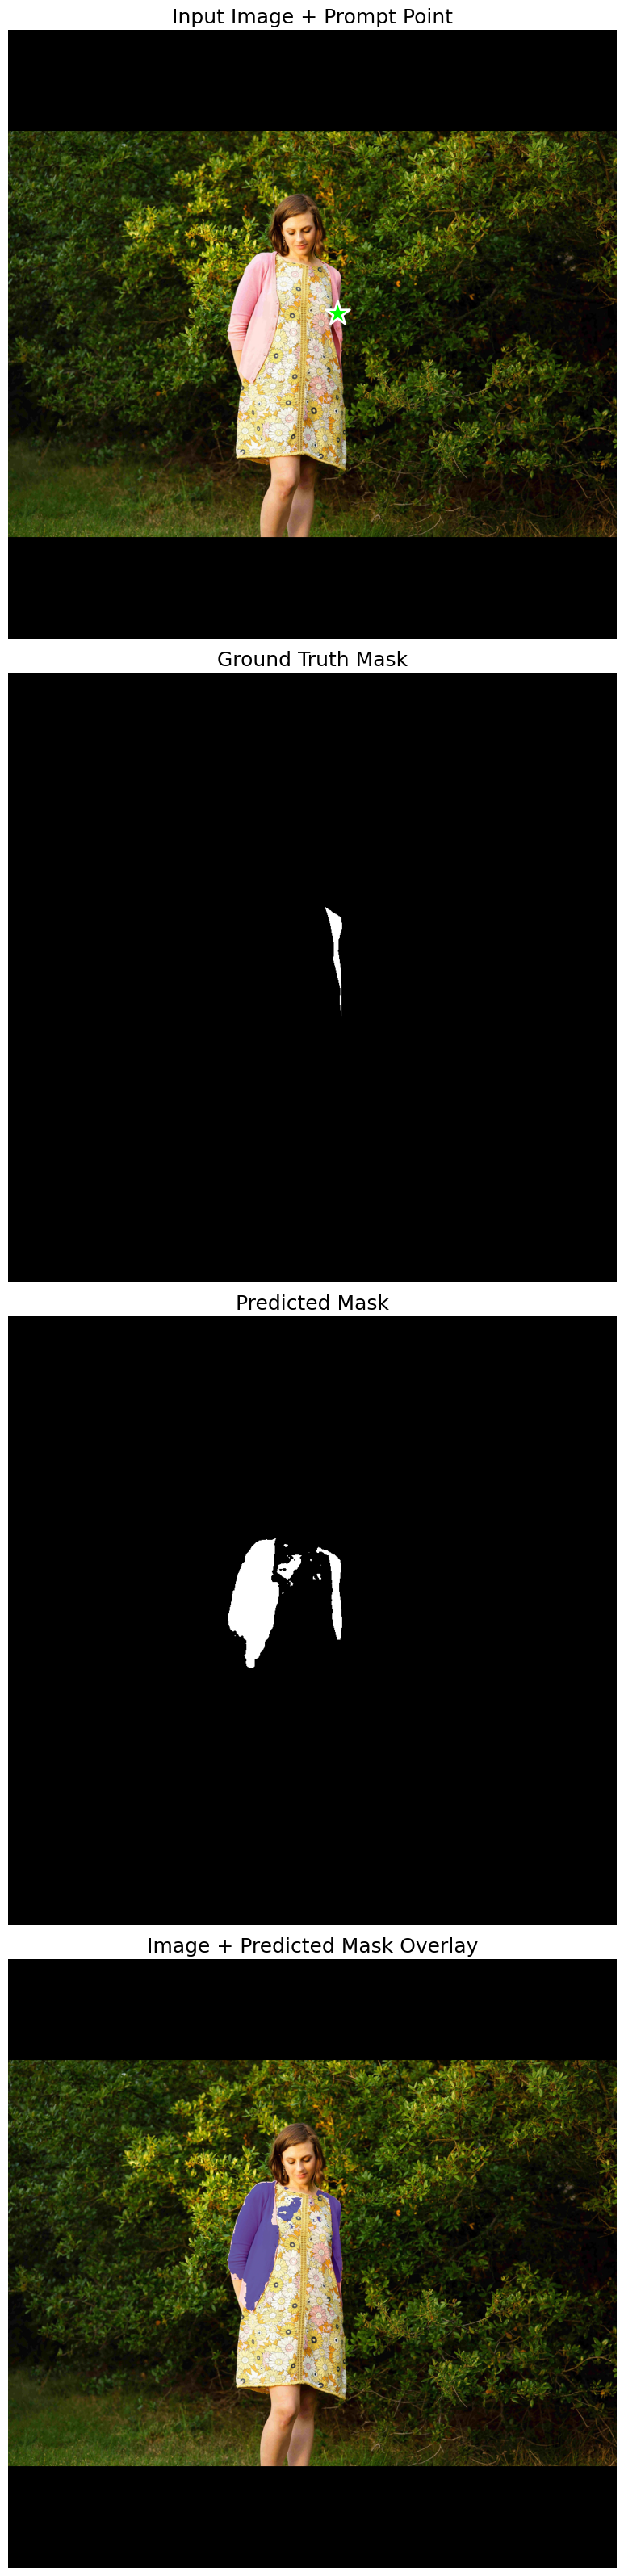

In [36]:
instance = random.choice(test_instances)

result = run_single_instance_inference(
    predictor,
    fashion_ds["test"],
    instance,
    coco,
    DEVICE
)

plot_inference_results(result)

### Evaluation :

In [46]:
def pixel_metrics(pred_mask, gt_mask, threshold=None, eps=1e-9):
    if threshold is not None:
        pred = (pred_mask >= threshold)
    else:
        pred = pred_mask.astype(bool)
    gt = gt_mask.astype(bool)

    tp = int(np.logical_and(pred, gt).sum())
    fp = int(np.logical_and(pred, ~gt).sum())
    fn = int(np.logical_and(~pred, gt).sum())

    if (not gt.any()) and (not pred.any()):
        return {"precision": 1.0, "recall": 1.0, "f1": 1.0, "iou": 1.0, "tp":0, "fp":0, "fn":0}

    prec = tp / (tp + fp + eps)
    rec  = tp / (tp + fn + eps)
    f1   = 2 * prec * rec / (prec + rec + eps)
    iou  = tp / (tp + fp + fn + eps)
    intersection = np.sum(pred & gt)
    dice = (2. * intersection + eps) / (np.sum(pred) + np.sum(gt) + eps)


    return {"precision": prec, "recall": rec, "f1": f1, "iou": iou, "dice" : dice,"tp":tp, "fp":fp, "fn":fn}

In [47]:

all_pixel = []
all_instance = []
valid_count = 0

for instance in tqdm(test_instances, desc="Evaluating Test Set"):
    result = run_single_instance_inference(predictor, fashion_ds["test"], instance, coco, DEVICE)
    if result is None:
        continue

    pred_mask = result["pred_mask"]    
    gt_mask = result["gt_mask"]       
    bin_pred = (pred_mask >= 0.5) if pred_mask.dtype.kind == 'f' else (pred_mask > 0)

    pix = pixel_metrics(bin_pred, gt_mask, threshold=0.5)
    all_pixel.append(pix)


    valid_count += 1

if valid_count == 0:
    print("No valid instances evaluated.")
else:
    df_pix = pd.DataFrame(all_pixel)
    
    print(f"Evaluated {valid_count} images\n")
    print("Pixel-wise metrics (mean ± std):")
    print(df_pix[["iou","dice","f1","precision","recall"]].agg(["mean","std"]).round(4).T)
    
    

Evaluating Test Set:   0%|          | 0/7 [00:00<?, ?it/s]

Shape of resized+padded image: (1024, 1024, 3) dtype: uint8
Prompt points: [[432.128 431.632]]
Point labels: [1]
torch.Size([1, 256, 64, 64]) torch.Size([256, 64, 64])
Shape of resized+padded image: (1024, 1024, 3) dtype: uint8
Prompt points: [[555.008 456.208]]
Point labels: [1]
torch.Size([1, 256, 64, 64]) torch.Size([256, 64, 64])
Shape of resized+padded image: (1024, 1024, 3) dtype: uint8
Prompt points: [[401.23734 408.93335]]
Point labels: [1]
torch.Size([1, 256, 64, 64]) torch.Size([256, 64, 64])
Shape of resized+padded image: (1024, 1024, 3) dtype: uint8
Prompt points: [[449.36533 580.96533]]
Point labels: [1]
torch.Size([1, 256, 64, 64]) torch.Size([256, 64, 64])
Shape of resized+padded image: (1024, 1024, 3) dtype: uint8
Prompt points: [[555.28    500.47998]]
Point labels: [1]
torch.Size([1, 256, 64, 64]) torch.Size([256, 64, 64])
Shape of resized+padded image: (1024, 1024, 3) dtype: uint8
Prompt points: [[473.36 645.12]]
Point labels: [1]
torch.Size([1, 256, 64, 64]) torch.Si

In [49]:
df_pix[["iou","dice","f1","precision","recall"]].agg(["mean","std"]).round(4).T

,mean,std
iou,0.3482,0.3268
dice,0.4463,0.3438
f1,0.4463,0.3438
precision,0.4996,0.3767
recall,0.8162,0.3553
